<a href="https://colab.research.google.com/github/CS222-UIUC/course-project-mri-detector/blob/ViT_Model/ViT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Data

In [2]:
#!wget http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar

In [3]:
# !wget https://www.kaggle.com/datasets/denizkavi1/brain-tumor/download?datasetVersionNumber=2

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# !wget -P /content/gdrive/MyDrive/Colab\ Notebooks/Datasets http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar

In [6]:
!mkdir /content/brain_tumor_dataset
!mkdir /content/brain_tumor_dataset/no_tumor

In [7]:
!tar -xvf /content/gdrive/MyDrive/Colab\ Notebooks/Datasets/IXI-T1.tar -C /content/brain_tumor_dataset/no_tumor

IXI002-Guys-0828-T1.nii.gz
IXI012-HH-1211-T1.nii.gz
IXI013-HH-1212-T1.nii.gz
IXI014-HH-1236-T1.nii.gz
IXI015-HH-1258-T1.nii.gz
IXI016-Guys-0697-T1.nii.gz
IXI017-Guys-0698-T1.nii.gz
IXI019-Guys-0702-T1.nii.gz
IXI020-Guys-0700-T1.nii.gz
IXI021-Guys-0703-T1.nii.gz
IXI022-Guys-0701-T1.nii.gz
IXI023-Guys-0699-T1.nii.gz
IXI024-Guys-0705-T1.nii.gz
IXI025-Guys-0852-T1.nii.gz
IXI026-Guys-0696-T1.nii.gz
IXI027-Guys-0710-T1.nii.gz
IXI028-Guys-1038-T1.nii.gz
IXI029-Guys-0829-T1.nii.gz
IXI030-Guys-0708-T1.nii.gz
IXI031-Guys-0797-T1.nii.gz
IXI033-HH-1259-T1.nii.gz
IXI034-HH-1260-T1.nii.gz
IXI035-IOP-0873-T1.nii.gz
IXI036-Guys-0736-T1.nii.gz
IXI037-Guys-0704-T1.nii.gz
IXI038-Guys-0729-T1.nii.gz
IXI039-HH-1261-T1.nii.gz
IXI040-Guys-0724-T1.nii.gz
IXI041-Guys-0706-T1.nii.gz
IXI042-Guys-0725-T1.nii.gz
IXI043-Guys-0714-T1.nii.gz
IXI044-Guys-0712-T1.nii.gz
IXI045-Guys-0713-T1.nii.gz
IXI046-Guys-0824-T1.nii.gz
IXI048-HH-1326-T1.nii.gz
IXI049-HH-1358-T1.nii.gz
IXI050-Guys-0711-T1.nii.gz
IXI051-HH-1328-T1.ni

In [8]:
!mkdir /content/brain_tumor_dataset/yes_tumor

In [9]:
!unzip /content/gdrive/MyDrive/Colab\ Notebooks/Datasets/archive.zip -d /content/brain_tumor_dataset/yes_tumor

Archive:  /content/gdrive/MyDrive/Colab Notebooks/Datasets/archive.zip
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2300.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2301.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2302.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2303.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2304.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2305.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2306.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2307.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2308.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2309.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2310.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2311.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2312.png  
  inflating: /content/brain_tumor_dataset/yes_tumor/1/2313.png  
  inflating: /conte

In [10]:
!rm -r brain_tumor_dataset/yes_tumor/1
!rm -r brain_tumor_dataset/yes_tumor/3

In [11]:
!pip -q install vit_pytorch linformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00


# Setting Up

In [12]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import cv2

import glob
from itertools import chain
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from linformer import Linformer

from vit_pytorch.efficient import ViT

In [13]:
#Training Specs
batch_size = 32
epochs = 30
lr = 0.001
gamma = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Processing

In [14]:
import nibabel as nib
from pathlib import Path

healthy_paths = glob.glob("./brain_tumor_dataset/no_tumor/*.nii.gz")
for img_path in healthy_paths:
  scan = nib.load(img_path)
  scan = scan.get_fdata()
  p = scan[:,-round(scan.shape[2]/2),:].astype(np.uint8) #loses information
  img = Image.fromarray(p)
  png_img_path = "brain_tumor_dataset/no_tumor/" + Path(Path(img_path).stem).stem + ".png"
  img.save(png_img_path)
  os.remove(img_path)

For Dataset With Tumor:


Back view:
- 0.png - 103.png

BEV:
- 1000+.png

Side view:
- 200-1000.png

In [15]:
tumor_paths = glob.glob("./brain_tumor_dataset/yes_tumor/2/*.png")
# tumor_paths = glob.glob("./brain_tumor_dataset/yes_tumor/*.png")
# print(Path(tumor_paths[0]).stem)
for img_path in tumor_paths:
  if int(Path(img_path).stem) >= 1000:
     os.replace(img_path, "./brain_tumor_dataset/yes_tumor/" + Path(img_path).stem + ".png")

553


In [16]:
!rm -r brain_tumor_dataset/yes_tumor/2

In [17]:
#Data Processing
full_list = glob.glob("./brain_tumor_dataset/**/*.png", recursive=True)
print("Full Data: ",len(full_list))

for img_path in full_list:
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # b, g, r = cv2.split(img)
  # img = cv2.merge([r,g,b])
  cv2.imwrite(img_path, img)

train_list, test_list = train_test_split(full_list,
                                         test_size=0.2)
labels = [(1 if (path.split('/')[-2].split('.')[0] == 'yes_tumor') else 0) for path in train_list]

Full Data:  1091


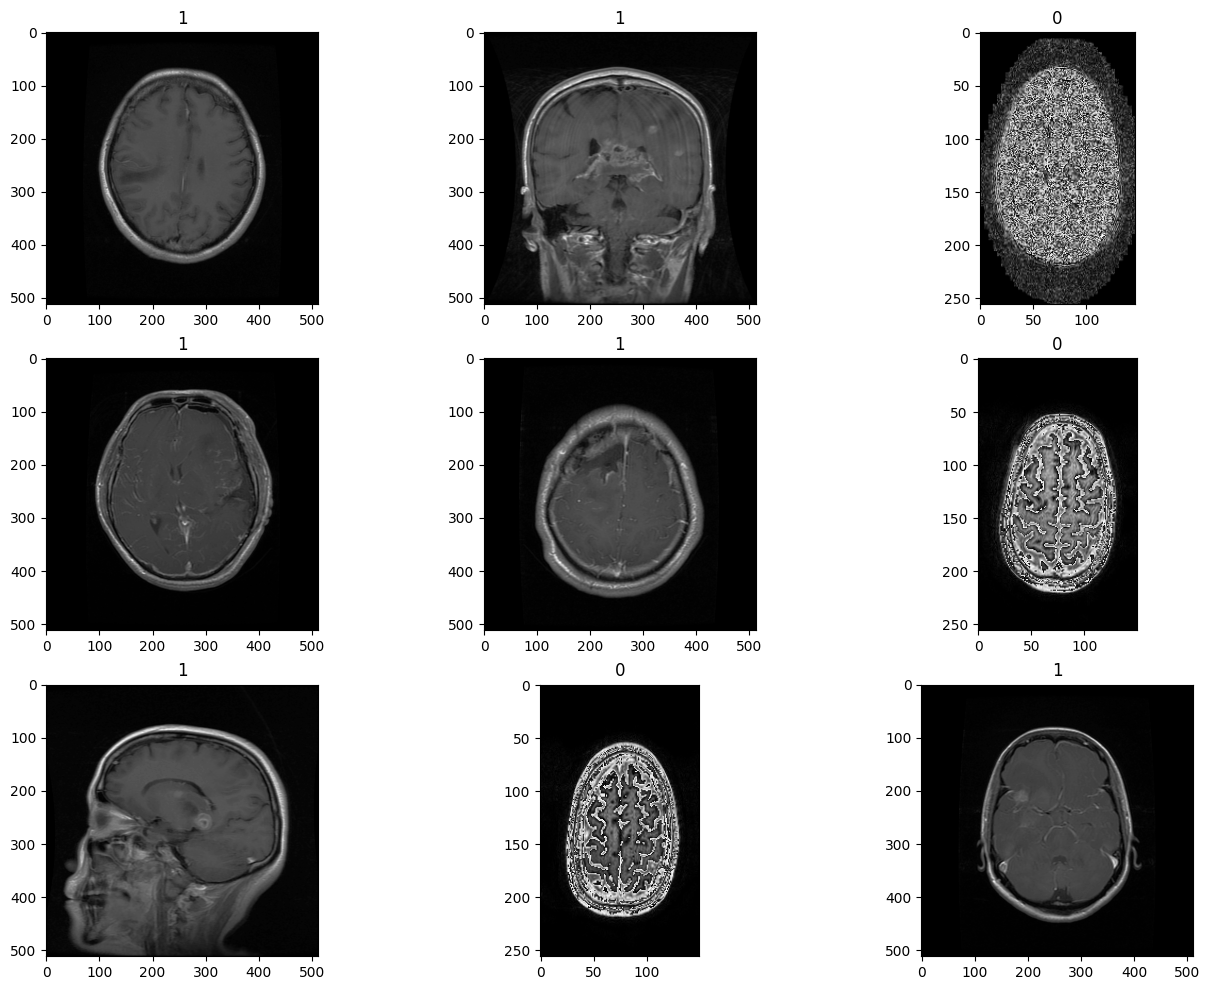

In [18]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img, cmap='gray')

# Preparing Dataset

In [19]:
train_list, val_list = train_test_split(train_list,
                                        test_size=0.2,
                                        stratify=labels)

In [20]:
print("Train Data: ",len(train_list))
print("Validation Data: ",len(val_list))
print("Test Data: ",len(test_list))

Train Data:  697
Validation Data:  175
Test Data:  219


In [21]:
#Image Augmentation
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]
)

In [38]:
#Dataset
class MRIDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = (1 if (img_path.split('/')[-2].split('.')[0] == 'yes_tumor') else 0)
        label = torch.from_numpy(np.asarray(label))
        return img_transformed, label

In [23]:
# Create train, validation, and test datasets
train_dataset = MRIDataset(train_list, transform=train_transforms)
val_dataset = MRIDataset(val_list, transform=test_transforms)
test_dataset = MRIDataset(test_list, transform=test_transforms)


In [24]:
# create data loaders for the training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Model

In [25]:
#Line Transformer
efficient_transformer = Linformer(
    dim=128,
    seq_len = 49+1, #7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [26]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=1
).to(device)

# Model Training

In [27]:
#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [28]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc/len(val_loader)
            epoch_val_loss += val_loss/len(val_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.8885 - acc: 0.5151 - val_loss : 0.7022 - val_acc: 0.5250



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6919 - acc: 0.5456 - val_loss : 0.6981 - val_acc: 0.5368



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6060 - acc: 0.6686 - val_loss : 0.9581 - val_acc: 0.5108



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5324 - acc: 0.7334 - val_loss : 1.0143 - val_acc: 0.5212



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.5798 - acc: 0.6989 - val_loss : 0.6325 - val_acc: 0.6774



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.5361 - acc: 0.7205 - val_loss : 0.7094 - val_acc: 0.4990



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.4832 - acc: 0.7494 - val_loss : 0.9349 - val_acc: 0.5375



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4628 - acc: 0.7835 - val_loss : 0.9047 - val_acc: 0.5969



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.4516 - acc: 0.7726 - val_loss : 0.8147 - val_acc: 0.6135



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.4831 - acc: 0.7551 - val_loss : 0.8877 - val_acc: 0.4865



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.4253 - acc: 0.7991 - val_loss : 0.7014 - val_acc: 0.5837



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.3493 - acc: 0.8436 - val_loss : 1.4378 - val_acc: 0.5993



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.4099 - acc: 0.8109 - val_loss : 1.4601 - val_acc: 0.5101



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.4040 - acc: 0.8144 - val_loss : 0.7743 - val_acc: 0.7049



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.3720 - acc: 0.8369 - val_loss : 0.9838 - val_acc: 0.6351



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.3299 - acc: 0.8527 - val_loss : 0.8949 - val_acc: 0.6097



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.3152 - acc: 0.8623 - val_loss : 1.7257 - val_acc: 0.6052



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.3032 - acc: 0.8706 - val_loss : 0.9481 - val_acc: 0.6142



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.2762 - acc: 0.8841 - val_loss : 0.3539 - val_acc: 0.8573



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.2890 - acc: 0.8834 - val_loss : 1.1217 - val_acc: 0.5962



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.2344 - acc: 0.9111 - val_loss : 1.5073 - val_acc: 0.5941



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.3128 - acc: 0.8592 - val_loss : 0.7038 - val_acc: 0.7257



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.2202 - acc: 0.8973 - val_loss : 1.2509 - val_acc: 0.5934



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.2558 - acc: 0.8923 - val_loss : 1.5862 - val_acc: 0.5524



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.2454 - acc: 0.8947 - val_loss : 0.6117 - val_acc: 0.7667



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.2335 - acc: 0.8973 - val_loss : 0.9468 - val_acc: 0.6417



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.1863 - acc: 0.9243 - val_loss : 0.5922 - val_acc: 0.8007



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.1849 - acc: 0.9205 - val_loss : 1.4680 - val_acc: 0.6306



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.1589 - acc: 0.9391 - val_loss : 0.2853 - val_acc: 0.8899



  0%|          | 0/22 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.1822 - acc: 0.9201 - val_loss : 0.5870 - val_acc: 0.6872



# Saving Checkpoint

In [33]:
checkpoint_path = "gdrive/MyDrive/Colab Notebooks/Datasets/model_checkpoint.pth"

#save model checkpoint
torch.save(model.state_dict(), checkpoint_path)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): Fe

# Prediction

In [46]:
checkpoint_path = "gdrive/MyDrive/Colab Notebooks/Datasets/model_checkpoint.pth"

#load model from checkpoint
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): Fe

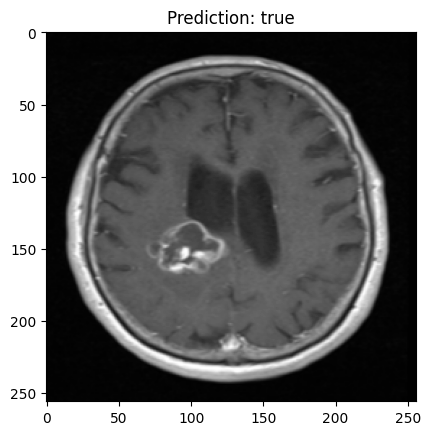

In [55]:
#with torch.no_grad():
with torch.inference_mode():
    predict_img_paths = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/Datasets/222_Predictions/*.png")
    for predict_img_path in predict_img_paths:
      predict_img = cv2.imread(predict_img_path)
      predict_img = cv2.cvtColor(predict_img, cv2.COLOR_BGR2GRAY)
      predict_img = cv2.resize(predict_img, (256, 256))
      cv2.imwrite(predict_img_path, predict_img)

      transformer = transforms.Compose(
          [
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
          ])
      
      predict_img = Image.open(predict_img_path)

      predict_img_tensor = transformer(predict_img)
      predict_img_tensor = predict_img_tensor.view(1, 1, 224, 224)

      prediction = model(predict_img_tensor)
      
      classification_prediction = "true" if np.argmax(prediction)==1 else "false"
      
      plt.imshow(predict_img, cmap='gray')
      plt.title(f'Prediction: {classification_prediction}')
      plt.show()